In [718]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns                               
import json
import os 
from sklearn.preprocessing import StandardScaler

In [719]:
# 資料前處理 (一): 刪除每個 Label 的前後 n 筆資料
def remove_first_last_n(data, label_column, n=20):
    data = data.sort_values(by=label_column).reset_index(drop=True)
    processed_data = pd.DataFrame(columns=data.columns)
    for label, group in data.groupby(label_column):
        if len(group) > 2 * n:
            group = group.iloc[n:-n]
        else:
            group = pd.DataFrame()  # 若資料不足，刪除整個群組
        processed_data = pd.concat([processed_data, group], ignore_index=True)
    return processed_data

def fill_nan_with_mean(processed_data,label_column):
    data_imputed = processed_data.groupby(label_column).apply(
        lambda group: group.fillna(group.mean())
    ).reset_index()
    return data_imputed

# 資料前處理 (二): 用 KNNImputer 填補缺失值
def KNN_inputer_fill_nan(processed_data, n=5):
    # 確定數值型與類別型欄位
    numeric_columns = processed_data.select_dtypes(include=['float', 'int']).columns
    non_numeric_columns = processed_data.select_dtypes(exclude=['float', 'int']).columns

    # 取出數值型資料
    numeric_data = processed_data[numeric_columns]

    # 使用 KNNImputer 填補數值型缺失值
    imputer = KNNImputer(n_neighbors=n)
    numeric_data_imputed = pd.DataFrame(imputer.fit_transform(numeric_data), columns=numeric_columns)

    # 填補類別型資料的缺失值（使用 mode）
    categorical_data = processed_data[non_numeric_columns].copy()
    for col in categorical_data.columns:
        if categorical_data[col].isnull().any():
            categorical_data[col].fillna(categorical_data[col].mode()[0], inplace=True)
    # 合併數值型與類別型資料
    data_imputed = pd.concat([numeric_data_imputed, categorical_data.reset_index(drop=True)], axis=1)
    return data_imputed

def plot_class_distribution(data, label_column, title):
    plt.figure(figsize=(8, 6))
    sns.countplot(x=label_column, data=data, order=data[label_column].value_counts().index)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

# 訓練 KNN 模型
def train_knn_model(X_train, y_train, n_neighbors=5):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    return knn

In [720]:
traindate = '2024_12_14'
testdate = '2025_01_10'

with_data = 'distance'

In [721]:
train_path = f'timestamp_allignment_Balanced_{traindate}_rtt_logs.csv'
test_path = f'timestamp_allignment_Balanced_{testdate}_rtt_logs.csv'

# train_path = f'standalized_timestamp_allignment_{traindate}_rtt_logs.csv'
# test_path = f'standalized_timestamp_allignment_{testdate}_rtt_logs.csv'

In [ ]:
# selected_columns = ['Label', 'AP1_Rssi','AP2_Rssi','AP3_Rssi','AP4_Rssi']

# selected_columns = ['Label', 'AP1_Rssi','AP2_Rssi','AP3_Rssi','AP4_Rssi']

# selected_columns = ['Label', 'AP1_Distance (mm)','AP2_Distance (mm)','AP3_Distance (mm)'] 
# 
selected_columns = ['Label', 'AP1_Rssi','AP2_Rssi','AP3_Rssi','AP4_Rssi','AP1_Distance (mm)','AP2_Distance (mm)','AP3_Distance (mm)','AP4_Distance (mm)'] 
# 
# selected_columns = ['Label', 'AP1_Corrected Distance (mm)','AP2_Corrected Distance (mm)','AP3_Corrected Distance (mm)','AP4_Corrected Distance (mm)'] 

# selected_columns = ['Label', 'AP1_Rssi','AP2_Rssi','AP3_Rssi','AP4_Rssi',
#                     'AP1_StdDev (mm)','AP2_StdDev (mm)','AP3_StdDev (mm)','AP4_StdDev (mm)'] 

# selected_columns = ['Label', 'AP1_Distance (mm)','AP2_Distance (mm)','AP3_Distance (mm)','AP4_Distance (mm)',
#                     'AP1_Rssi','AP2_Rssi','AP3_Rssi','AP4_Rssi']

# selected_columns = ['Label', 'AP1_Distance (mm)','AP2_Distance (mm)','AP3_Distance (mm)','AP4_Distance (mm)',
#                     'AP1_StdDev (mm)','AP2_StdDev (mm)','AP3_StdDev (mm)','AP4_StdDev (mm)']   

# selected_columns = ['Label', 'AP1_Distance (mm)','AP2_Distance (mm)','AP3_Distance (mm)','AP4_Distance (mm)',
#                     'AP1_StdDev (mm)','AP2_StdDev (mm)','AP3_StdDev (mm)','AP4_StdDev (mm)',
#                     'AP1_Rssi','AP2_Rssi','AP3_Rssi','AP4_Rssi']  

# selected_columns = ['Label', 'AP1_Corrected Distance (mm)','AP2_Corrected Distance (mm)','AP3_Corrected Distance (mm)','AP4_Corrected Distance (mm)',
#                      'AP1_Rssi','AP2_Rssi','AP3_Rssi','AP4_Rssi']

In [723]:
# 讀取資料
train_data = pd.read_csv(train_path, usecols=selected_columns)
test_data = pd.read_csv(test_path, usecols=selected_columns)

In [724]:
n_remove = 20
n_neighbors = 5

C:\Users\吳定洋\AppData\Local\Temp\ipykernel_13620\1857334481.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  processed_data = pd.concat([processed_data, group], ignore_index=True)
C:\Users\吳定洋\AppData\Local\Temp\ipykernel_13620\1857334481.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  processed_data = pd.concat([processed_data, group], ignore_index=True)


   AP1_Distance (mm)  AP1_Rssi  AP2_Rssi  AP3_Rssi  AP4_Rssi
0             4233.0     -61.0     -73.0     -67.0     -55.0
1             3838.0     -53.0     -73.0     -67.0     -55.0
2             4155.0     -62.0     -73.0     -66.0     -49.0
3             3960.0     -62.0     -72.0     -65.0     -54.0
4             3960.0     -63.0     -72.0     -67.0     -54.0


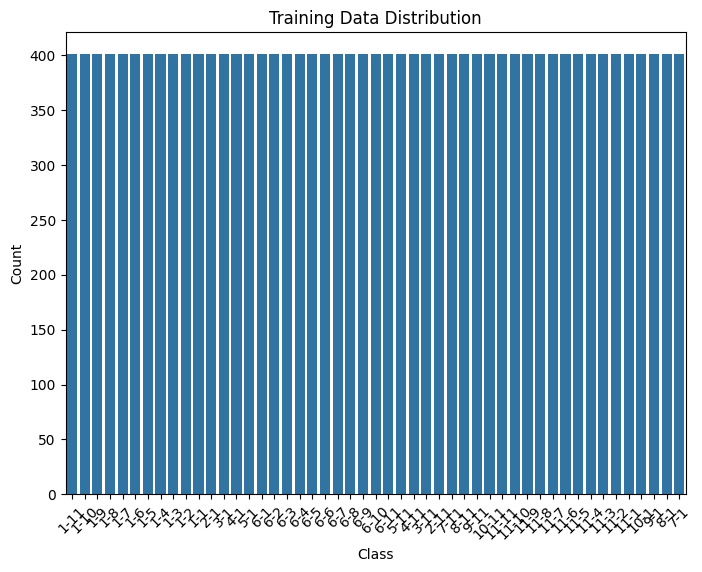

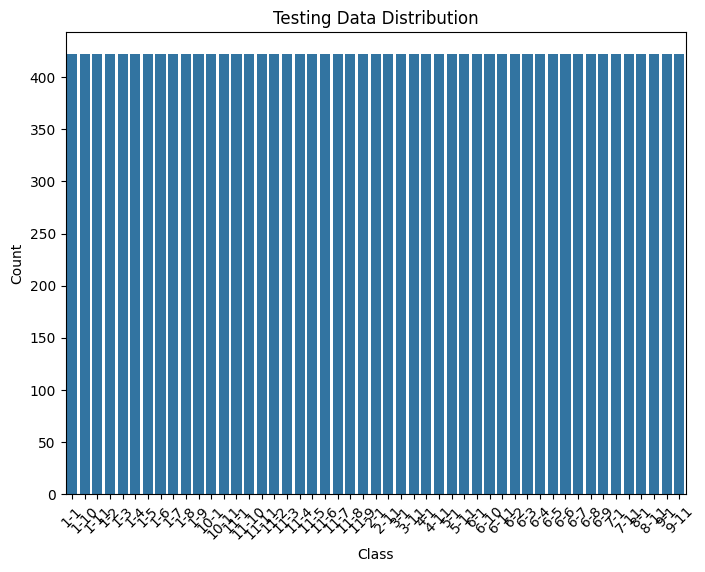

In [725]:
# 資料清理
train_data_p = remove_first_last_n(train_data, label_column=['Label'], n=n_remove)
test_data_p = remove_first_last_n(test_data, label_column=['Label'], n=n_remove)


train_data_p = fill_nan_with_mean(train_data_p,label_column=['Label'])
test_data_p = fill_nan_with_mean(test_data_p,label_column=['Label'])


# print(train_data_p)

# 分離特徵與標籤
X_train = train_data_p.drop(columns=['level_1','Label'])
y_train = train_data_p['Label']
X_test = test_data_p.drop(columns=['level_1','Label'])
y_test = test_data_p['Label']

print(X_train.head())



# 訓練資料分佈
plot_class_distribution(train_data, label_column='Label', title="Training Data Distribution")

# 測試資料分佈
plot_class_distribution(test_data, label_column='Label', title="Testing Data Distribution")



In [726]:
# 使用 Z-score 標準化
scaler = StandardScaler() 
selected_columns.remove('Label')

scaler.fit(X_train[selected_columns])

# 標準化數據
X_train.loc[:, selected_columns] = scaler.transform(X_train[selected_columns])
X_test.loc[:, selected_columns] = scaler.transform(X_test[selected_columns])

print(X_train.head())
print(X_test.head())


   AP1_Distance (mm)  AP1_Rssi  AP2_Rssi  AP3_Rssi  AP4_Rssi
0           0.615778 -0.120783 -1.059321 -1.674492  0.415218
1           0.449047  1.584552 -1.059321 -1.674492  0.415218
2           0.582854 -0.333950 -1.059321 -1.484683  1.345117
3           0.500544 -0.333950 -0.876413 -1.294873  0.570201
4           0.500544 -0.547117 -0.876413 -1.674492  0.570201
   AP1_Distance (mm)  AP1_Rssi  AP2_Rssi  AP3_Rssi  AP4_Rssi
0           0.517006 -0.973450 -0.144781 -1.294873  0.570201
1           0.467620 -1.186617 -0.144781 -1.484683  0.570201
2           0.533468 -0.973450 -0.144781 -0.915254  1.190134
3           0.434696 -0.973450 -0.144781 -1.294873  0.570201
4           0.549930 -0.973450 -0.144781 -1.294873  0.570201


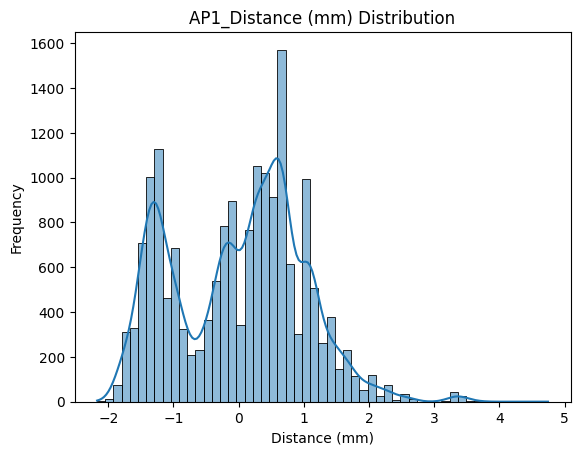

AP1_Distance Statistics:
count    1.768900e+04
mean    -1.156856e-16
std      1.000028e+00
min     -2.172207e+00
25%     -9.671053e-01
50%      1.704600e-01
75%      6.816257e-01
max      4.746047e+00
Name: AP1_Distance (mm), dtype: float64


In [727]:
import matplotlib.pyplot as plt
import seaborn as sns

# 檢查原始數據分佈
sns.histplot(X_train['AP1_Distance (mm)'], kde=True)
plt.title("AP1_Distance (mm) Distribution")
plt.xlabel("Distance (mm)")
plt.ylabel("Frequency")
plt.show()

# 檢查極端值（例如分位數）
print("AP1_Distance Statistics:")
print(X_train['AP1_Distance (mm)'].describe())

In [ ]:
# 將 ditance 權重設為 n 被

X_train['AP1_Distance (mm)'] = X_train['AP1_Distance (mm)'] * 3
X_train['AP2_Distance (mm)'] = X_train['AP2_Distance (mm)'] * 3
X_train['AP3_Distance (mm)'] = X_train['AP3_Distance (mm)'] * 3
X_train['AP4_Distance (mm)'] = X_train['AP4_Distance (mm)'] * 3
X_test['AP1_Distance (mm)'] = X_test['AP1_Distance (mm)'] * 3
X_test['AP2_Distance (mm)'] = X_test['AP2_Distance (mm)'] * 3
X_test['AP3_Distance (mm)'] = X_test['AP3_Distance (mm)'] * 3
X_test['AP4_Distance (mm)'] = X_test['AP4_Distance (mm)'] * 3

print(X_train.head())
print(X_test.head())

   AP1_Distance (mm)  AP1_Rssi  AP2_Rssi  AP3_Rssi  AP4_Rssi
0           1.847333 -0.120783 -1.059321 -1.674492  0.415218
1           1.347142  1.584552 -1.059321 -1.674492  0.415218
2           1.748561 -0.333950 -1.059321 -1.484683  1.345117
3           1.501632 -0.333950 -0.876413 -1.294873  0.570201
4           1.501632 -0.547117 -0.876413 -1.674492  0.570201
   AP1_Distance (mm)  AP1_Rssi  AP2_Rssi  AP3_Rssi  AP4_Rssi
0           1.551018 -0.973450 -0.144781 -1.294873  0.570201
1           1.402860 -1.186617 -0.144781 -1.484683  0.570201
2           1.600403 -0.973450 -0.144781 -0.915254  1.190134
3           1.304088 -0.973450 -0.144781 -1.294873  0.570201
4           1.649789 -0.973450 -0.144781 -1.294873  0.570201


In [729]:
label_to_coordinates = {
    "1-1": (0, 0), "1-2": (0.6, 0), "1-3": (1.2, 0), "1-4": (1.8, 0), "1-5": (2.4, 0), "1-6": (3.0, 0),"1-7": (3.6, 0), "1-8": (4.2, 0), "1-9": (4.8, 0), "1-10": (5.4, 0), "1-11": (6.0, 0),
    "2-1": (0, 0.6), "2-11": (6.0, 0.6),
    "3-1": (0, 1.2), "3-11": (6.0, 1.2),
    "4-1": (0, 1.8), "4-11": (6.0, 1.8),
    "5-1": (0, 2.4), "5-11": (6.0, 2.4),
    "6-1": (0, 3.0), "6-2": (0.6, 3.0), "6-3": (1.2, 3.0), "6-4": (1.8, 3.0), "6-5": (2.4, 3.0),"6-6": (3.0, 3.0), "6-7": (3.6, 3.0), "6-8": (4.2, 3.0), "6-9": (4.8, 3.0), "6-10": (5.4, 3.0), "6-11": (6.0, 3.0),
    "7-1": (0, 3.6), "7-11": (6.0, 3.6),
    "8-1": (0, 4.2), "8-11": (6.0, 4.2),
    "9-1": (0, 4.8), "9-11": (6.0, 4.8),
    "10-1": (0, 5.4), "10-11": (6.0, 5.4),
    "11-1": (0, 6.0), "11-2": (0.6, 6.0), "11-3": (1.2, 6.0), "11-4": (1.8, 6.0), "11-5": (2.4, 6.0),"11-6": (3.0, 6.0), "11-7": (3.6, 6.0), "11-8": (4.2, 6.0), "11-9": (4.8, 6.0), "11-10": (5.4, 6.0), "11-11": (6.0, 6.0)
}

In [730]:
# 訓練模型
knn = train_knn_model(X_train, y_train, n_neighbors=n_neighbors)

In [731]:
# 評估模型
report_save_path = f'transfer_report_{traindate}_data_to_train_{testdate}_data_to_test_{with_data}.txt'
y_pred = knn.predict(X_test)

# accuracy
accuracy = accuracy_score(y_test, y_pred)
# MDE
# Calculate MDE metrics
y_test_pred_coordinates = np.array([label_to_coordinates[label] for label in y_pred])
y_test_coordinates = np.array([label_to_coordinates[label] for label in y_test])

# 計算各點的距離
distances = np.linalg.norm(y_test_pred_coordinates - y_test_coordinates, axis=1)
mean_distance_error = np.mean(distances)


# 計算每個點的 MDE
pointwise_mde = {}
for label in np.unique(y_test):
    # 過濾對應於該標籤的測試點
    indices = np.where(y_test == label)
    if len(indices[0]) > 0:
        point_distances = distances[indices]
        pointwise_mde[label] = {
            "count": len(point_distances),
            "MDE": np.mean(point_distances)
        }
    else:
        pointwise_mde[label] = {
            "count": 0,
            "MDE": None
        }



In [732]:
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Mean Distance Error (MDE): {mean_distance_error:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=[str(label) for label in np.unique(y_test)]))

# 生成 classification report 並保存
report = classification_report(y_test, y_pred, output_dict=True)
# 將 MDE 加入 report
report["Mean Distance Error (MDE)"] = mean_distance_error
report["accuracy"] = accuracy  # 加入準確度
report["Pointwise MDE"] = pointwise_mde  # 加入每個點的 MDE


if not os.path.exists(report_save_path):
    with open(report_save_path, 'w') as f:
        f.write("")  # Create an empty file

with open(report_save_path, "w") as f:
    json.dump(report, f, indent=4)

print(f"Updated report with MDE saved to: {report_save_path}")

Test Accuracy: 0.2745
Mean Distance Error (MDE): 1.0831
Classification Report:
              precision    recall  f1-score   support

         1-1       0.15      0.13      0.14       382
        1-10       0.24      0.06      0.10       382
        1-11       0.00      0.00      0.00       382
         1-2       0.92      0.88      0.90       382
         1-3       0.93      0.88      0.90       382
         1-4       0.23      0.23      0.23       382
         1-5       0.24      0.15      0.19       382
         1-6       0.99      0.77      0.87       382
         1-7       0.60      0.52      0.56       382
         1-8       0.06      0.05      0.05       382
         1-9       0.02      0.02      0.02       382
        10-1       0.00      0.00      0.00       382
       10-11       0.65      0.07      0.13       382
        11-1       0.28      0.58      0.38       382
       11-10       0.31      0.07      0.12       382
       11-11       0.40      0.94      0.56       382
  

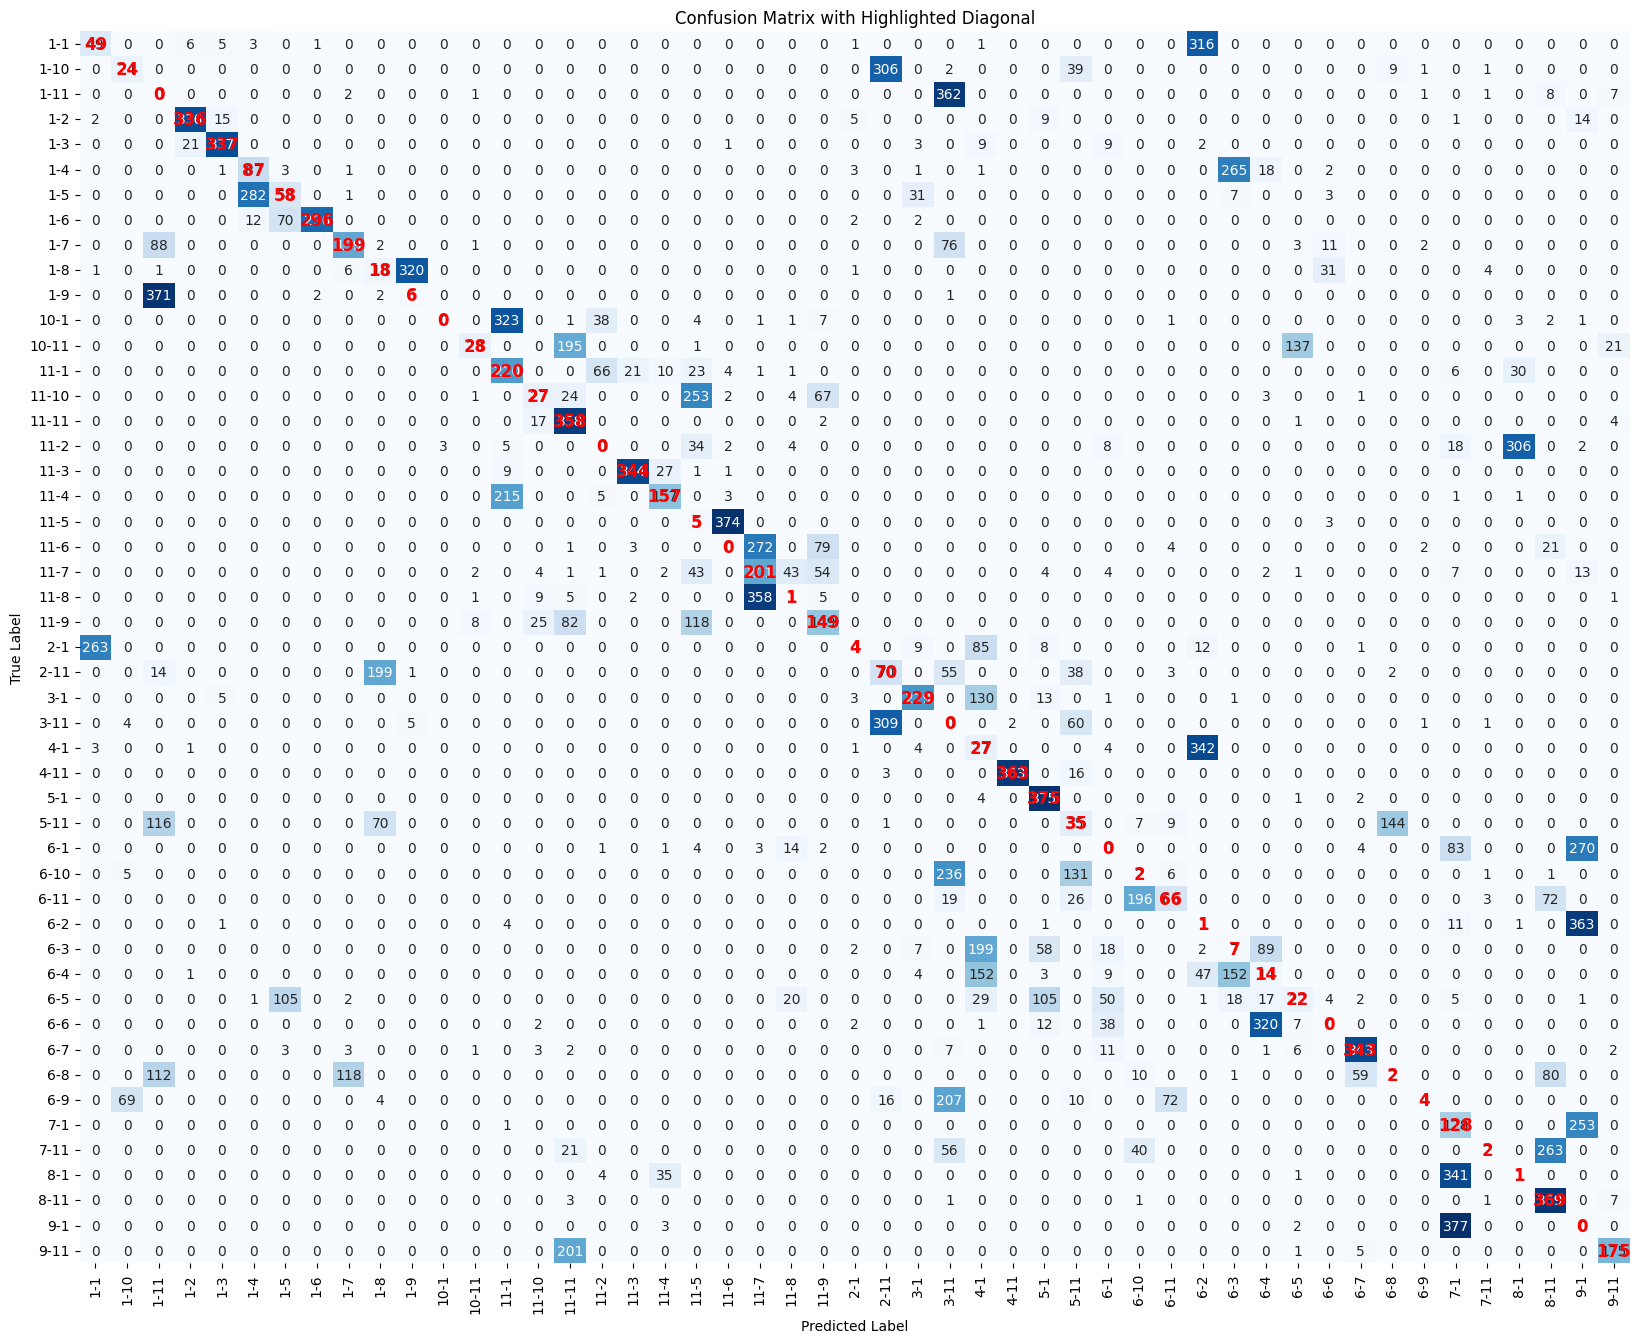

In [733]:
# 計算混淆矩陣
cm = confusion_matrix(y_test, y_pred)
num_classes = cm.shape[0]

plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test),
            cbar=False)

# 手動修改對角線文字顏色為紅色
for i in range(num_classes):
    plt.text(i + 0.5, i + 0.5, cm[i, i], 
                color="red", ha="center", va="center", fontsize=12, fontweight="bold")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix with Highlighted Diagonal")
plt.show()

{'1-1': {'precision': 0.1540880503144654, 'recall': 0.12827225130890052, 'f1-score': 0.14, 'support': 382.0}, '1-10': {'precision': 0.23529411764705882, 'recall': 0.06282722513089005, 'f1-score': 0.09917355371900827, 'support': 382.0}, '1-11': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 382.0}, '1-2': {'precision': 0.9205479452054794, 'recall': 0.8795811518324608, 'f1-score': 0.8995983935742972, 'support': 382.0}, '1-3': {'precision': 0.9258241758241759, 'recall': 0.8821989528795812, 'f1-score': 0.903485254691689, 'support': 382.0}, '1-4': {'precision': 0.22597402597402597, 'recall': 0.22774869109947643, 'f1-score': 0.22685788787483702, 'support': 382.0}, '1-5': {'precision': 0.24267782426778242, 'recall': 0.1518324607329843, 'f1-score': 0.18679549114331723, 'support': 382.0}, '1-6': {'precision': 0.9899665551839465, 'recall': 0.774869109947644, 'f1-score': 0.869309838472834, 'support': 382.0}, '1-7': {'precision': 0.5993975903614458, 'recall': 0.5209424083769634, 'f1

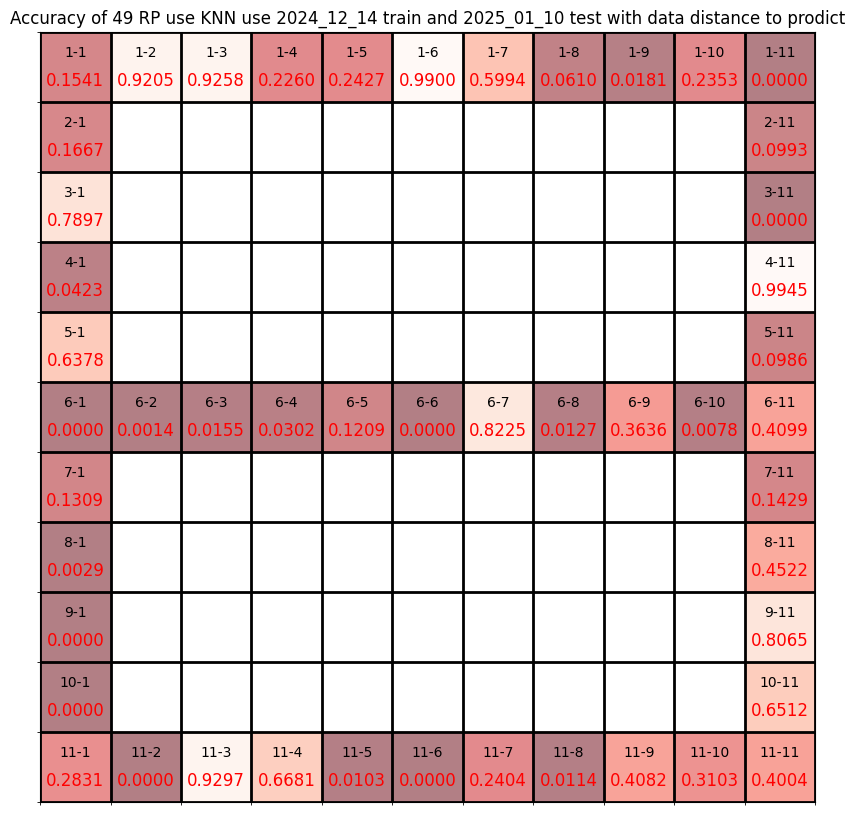

In [734]:
Title = f"Accuracy of 49 RP use KNN use {traindate} train and {testdate} test with data {with_data} to prodict"
file_path = f'transfer_report_{traindate}_data_to_train_{testdate}_data_to_test_{with_data}.txt'

# Load the figure.txt JSON file
with open(file_path) as file:
    data = json.load(file)

print(data)

# Filter out keys that are not class labels (e.g., "accuracy", "macro avg")
filtered_data = {k: v for k, v in data.items() if '-' in k}

print(filtered_data)

# Extract precision values without mapping
precision_values = {k: v['precision'] for k, v in filtered_data.items()}

precision_values

# Grid layout (11x11)
rows, cols = 11, 11
grid = np.full((rows, cols), np.nan)  # Initialize grid with NaN
labels = np.empty((rows, cols), dtype=object)  # Initialize grid for labels

# Populate the grid with precision values and labels (reverse row index for correct plotting)
for key, value in precision_values.items():
    if '-' in key:
        r, c = map(int, key.split('-'))
        grid[rows - r, c - 1] = value  # Reverse rows for top-left (1-1) to bottom-left (11-1)
        labels[rows - r, c - 1] = key

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.cm.Reds_r  # Color map

# 設定自定義顏色範圍
vmin = 0  # 最小值對應的顏色
vmax = np.nanmax(grid) * 0.5  # 最大值對應的顏色 (縮小範圍讓顏色對比更明顯)

log_grid = np.log(grid + 1e-6)  # 避免取 log(0)

# Draw grid with precision values and labels
for i in range(rows):
    for j in range(cols):
        value = grid[i, j]
        label = labels[i, j]
        if not np.isnan(value):
            ax.text(j, i + 0.2, f'{label}', ha='center', va='center', color='black', fontsize=10)
            ax.text(j, i - 0.2, f'{value:.4f}', ha='center', va='center', color='red', fontsize=12)
        rect_color = cmap(value / np.nanmax(grid)) if not np.isnan(value) else 'white'
        ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color, alpha=0.5))


# Format grid
ax.set_xlim(-0.5, cols - 0.5)
ax.set_ylim(-0.5, rows - 0.5)
ax.set_xticks(np.arange(-0.5, cols, 1), minor=True)
ax.set_yticks(np.arange(-0.5, rows, 1), minor=True)
ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

plt.title(Title)
plt.show()

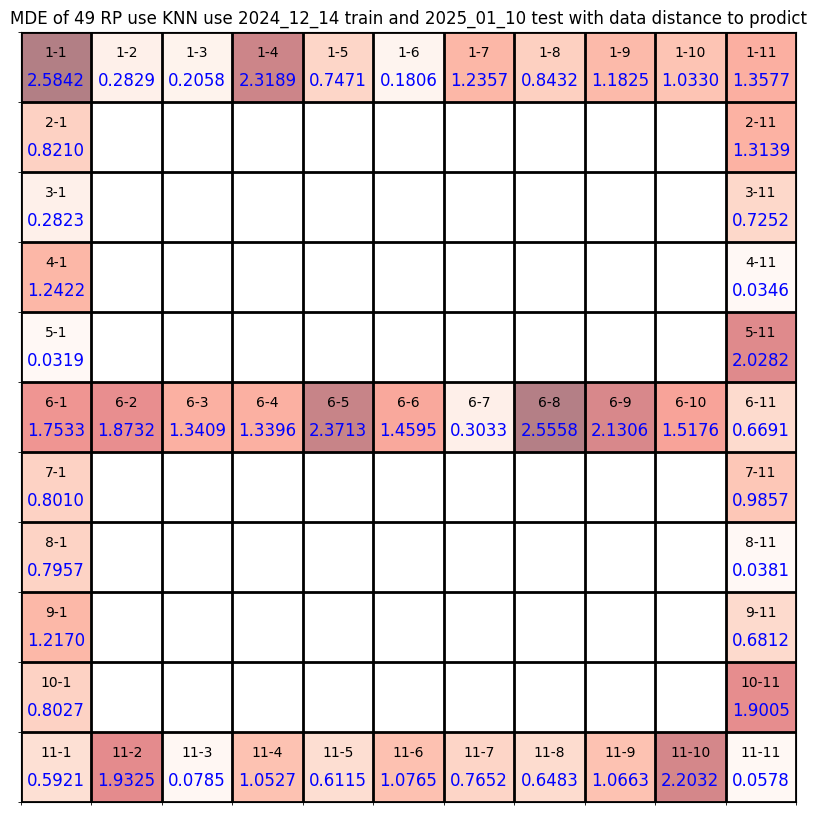

In [735]:
Title = f"MDE of 49 RP use KNN use {traindate} train and {testdate} test with data {with_data} to prodict"
file_path = f'transfer_report_{traindate}_data_to_train_{testdate}_data_to_test_{with_data}.txt'

# 載入 JSON 報告
with open(file_path) as file:
    mde_data = json.load(file)

# 提取 Pointwise MDE
pointwise_mde = mde_data.get("Pointwise MDE", {})

# 將 MDE 填入網格
rows, cols = 11, 11
grid = np.full((rows, cols), np.nan)  # 初始化網格
labels = np.empty((rows, cols), dtype=object)  # 初始化標籤

# 填充網格數據
for key, value in pointwise_mde.items():
    if '-' in key:
        r, c = map(int, key.split('-'))
        grid[rows - r, c - 1] = value["MDE"]  # 反轉行索引以正確對應圖表
        labels[rows - r, c - 1] = key

# 繪製圖表
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.cm.Reds  # 顏色映射

# 畫出每個網格
for i in range(rows):
    for j in range(cols):
        value = grid[i, j]
        label = labels[i, j]
        if not np.isnan(value):
            ax.text(j, i + 0.2, f'{label}', ha='center', va='center', color='black', fontsize=10)
            ax.text(j, i - 0.2, f'{value:.4f}', ha='center', va='center', color='blue', fontsize=12)
        rect_color = cmap(value / np.nanmax(grid)) if not np.isnan(value) else 'white'
        ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color, alpha=0.5))

# 格式化圖表
ax.set_xlim(-0.5, cols - 0.5)
ax.set_ylim(-0.5, rows - 0.5)
ax.set_xticks(np.arange(-0.5, cols, 1), minor=True)
ax.set_yticks(np.arange(-0.5, rows, 1), minor=True)
ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

plt.title(Title)
plt.show()


In [736]:
label_mapping = {
    '11': '1-1','10': '1-2','9': '1-3','8': '1-4','7': '1-5','6': '1-6','5': '1-7','4': '1-8','3': '1-9','2': '1-10','1': '1-11',
    '12': '2-1','30': '2-11',
    '13': '3-1','29': '3-11',
    '14': '4-1','28': '4-11',
    '15': '5-1','27': '5-11',
    '16': '6-1','17': '6-2','18': '6-3','19': '6-4','20': '6-5','21': '6-6','22': '6-7','23': '6-8','24': '6-9','25': '6-10','26': '6-11',
    '49': '7-1','31': '7-11',
    '48': '8-1','32': '8-11',
    '47': '9-1','33': '9-11',
    '46': '10-1','34': '10-11',
    '45': '11-1','44': '11-2','43': '11-3','42': '11-4','41': '11-5','40': '11-6','39': '11-7','38': '11-8','37': '11-9','36': '11-10','35': '11-11'
}

In [737]:
target_column = 'Label'  # 替換成目標欄位名稱

# # 替換目標欄位的 label
# # train
# train_data[target_column] = train_data[target_column].astype(str).map(label_mapping)
# # # test
# test_data[target_column] = test_data[target_column].astype(str).map(label_mapping)


# # 確認是否有未映射的值
# # train
# unmapped_values_train = train_data[target_column][train_data[target_column].isna()].unique()
# if len(unmapped_values_train) > 0:
#     print("以下值未找到對應的映射：", unmapped_values_train)
# # # test
# unmapped_values_test = test_data[target_column][test_data[target_column].isna()].unique()
# if len(unmapped_values_test) > 0:
#     print("以下值未找到對應的映射：", unmapped_values_test)

In [ ]:
def calculate_mde(model, test_data, selected_columns, zscore=False, distanceweight=1):
    selected_columns = selected_columns.copy()  # 建立副本，避免影響外部列表
    # print("DEBUG")
    # print(test_data.columns)

    test_data_p = remove_first_last_n(test_data, label_column=['Label'], n=n_remove)
    test_data_p = fill_nan_with_mean(test_data_p, label_column=['Label'])
    # print(test_data_p.head())

    selected_columns.remove('Label')  # 此操作只影響副本
    # print(selected_columns)
    
    X_test = test_data_p.drop(columns=['level_1', 'Label'])
    y_test = test_data_p['Label']

    if zscore:
        # 標準化
        X_test.loc[:, selected_columns] = scaler.transform(X_test[selected_columns])
        if distanceweight != 1:
            X_test['AP1_Distance (mm)'] = X_test['AP1_Distance (mm)'] * distanceweight
            X_test['AP2_Distance (mm)'] = X_test['AP2_Distance (mm)'] * distanceweight
            X_test['AP3_Distance (mm)'] = X_test['AP3_Distance (mm)'] * distanceweight
            X_test['AP4_Distance (mm)'] = X_test['AP4_Distance (mm)'] * distanceweight


    print(X_test.head())

    y_pred = model.predict(X_test)

    # MDE
    y_test_pred_coordinates = np.array([label_to_coordinates[label] for label in y_pred])
    y_test_coordinates = np.array([label_to_coordinates[label] for label in y_test])
    distances = np.linalg.norm(y_test_pred_coordinates - y_test_coordinates, axis=1)
    mean_distance_error = np.mean(distances)

    return mean_distance_error


  Label  AP1_Distance (mm)  AP1_Rssi  AP2_Rssi  AP3_Rssi  AP4_Rssi
0  1-11              444.0     -60.0     -71.0     -50.0     -62.0
1  1-11              366.0     -59.0     -71.0     -54.0     -66.0
2  1-11              288.0     -58.0     -71.0     -56.0     -64.0
3  1-11              366.0     -59.0     -71.0     -52.0     -58.0
4  1-11              327.0     -59.0     -71.0     -54.0     -62.0
   AP1_Distance (mm)  AP1_Rssi  AP2_Rssi  AP3_Rssi  AP4_Rssi
0           1.649789 -0.760283 -1.242229 -1.294873  0.725184
1           1.699175 -0.547117 -1.425137 -1.674492  0.880167
2           1.353474 -0.760283 -1.242229 -2.054111  0.725184
3           1.402860 -0.760283 -1.242229 -2.054111  0.725184
4           1.501632 -0.547117 -1.425137 -1.674492  1.190134


C:\Users\吳定洋\AppData\Local\Temp\ipykernel_13620\1857334481.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  processed_data = pd.concat([processed_data, group], ignore_index=True)


  Label  AP1_Distance (mm)  AP1_Rssi  AP2_Rssi  AP3_Rssi  AP4_Rssi
0   1-1             3960.0     -62.0     -72.0     -64.0     -47.0
1   1-1             4077.0     -62.0     -72.0     -64.0     -47.0
2   1-1             4038.0     -57.0     -72.0     -60.0     -45.0
3   1-1             3960.0     -62.0     -72.0     -63.0     -47.0
4   1-1             3960.0     -62.0     -72.0     -63.0     -48.0
   AP1_Distance (mm)  AP1_Rssi  AP2_Rssi  AP3_Rssi  AP4_Rssi
0           1.452246 -0.333950 -0.876413 -0.725444  1.655083
1           1.302821 -0.333950 -0.876413 -1.105064  1.500100
2           1.986627  1.797719 -0.876413 -1.105064  2.275016
3           1.353474 -0.333950 -0.876413 -1.105064  1.500100
4           1.353474 -0.333950 -0.876413 -1.105064  1.655083


C:\Users\吳定洋\AppData\Local\Temp\ipykernel_13620\1857334481.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  processed_data = pd.concat([processed_data, group], ignore_index=True)


  Label  AP1_Distance (mm)  AP1_Rssi  AP2_Rssi  AP3_Rssi  AP4_Rssi
0   1-1             3999.0     -61.0     -71.0     -62.0     -43.0
1   1-1             4155.0     -61.0     -71.0     -64.0     -47.0
2   1-1             3960.0     -61.0     -71.0     -64.0     -47.0
3   1-1             3921.0     -61.0     -71.0     -63.0     -47.0
4   1-1             4116.0     -60.0     -70.0     -64.0     -43.0
   AP1_Distance (mm)  AP1_Rssi  AP2_Rssi  AP3_Rssi  AP4_Rssi
0           1.699175  0.092384 -0.693505 -1.294873  1.655083
1           1.649789  0.092384 -0.693505 -0.915254  1.655083
2           1.600403  0.092384 -0.693505 -1.105064  1.655083
3           1.600403  1.158218 -0.693505 -1.105064  1.655083
4           1.797947 -0.120783 -0.693505 -0.915254  1.655083


C:\Users\吳定洋\AppData\Local\Temp\ipykernel_13620\1857334481.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  processed_data = pd.concat([processed_data, group], ignore_index=True)


  Label  AP1_Distance (mm)  AP1_Rssi  AP2_Rssi  AP3_Rssi  AP4_Rssi
0   1-1             3999.0     -65.0     -68.0     -65.0     -50.0
1   1-1             3921.0     -65.0     -68.0     -64.0     -54.0
2   1-1             4038.0     -65.0     -69.0     -64.0     -52.0
3   1-1             4038.0     -65.0     -68.0     -65.0     -54.0
4   1-1             4077.0     -65.0     -68.0     -64.0     -54.0
   AP1_Distance (mm)  AP1_Rssi  AP2_Rssi  AP3_Rssi  AP4_Rssi
0           1.551018 -0.973450 -0.144781 -1.294873  0.570201
1           1.402860 -1.186617 -0.144781 -1.484683  0.570201
2           1.600403 -0.973450 -0.144781 -0.915254  1.190134
3           1.304088 -0.973450 -0.144781 -1.294873  0.570201
4           1.649789 -0.973450 -0.144781 -1.294873  0.570201


C:\Users\吳定洋\AppData\Local\Temp\ipykernel_13620\1857334481.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  processed_data = pd.concat([processed_data, group], ignore_index=True)


Mean Distance Errors (MDE) for each test date:
2024_12_21: 1.1144
2024_12_27: 1.5125
2025_01_03: 1.5119
2025_01_10: 1.0831


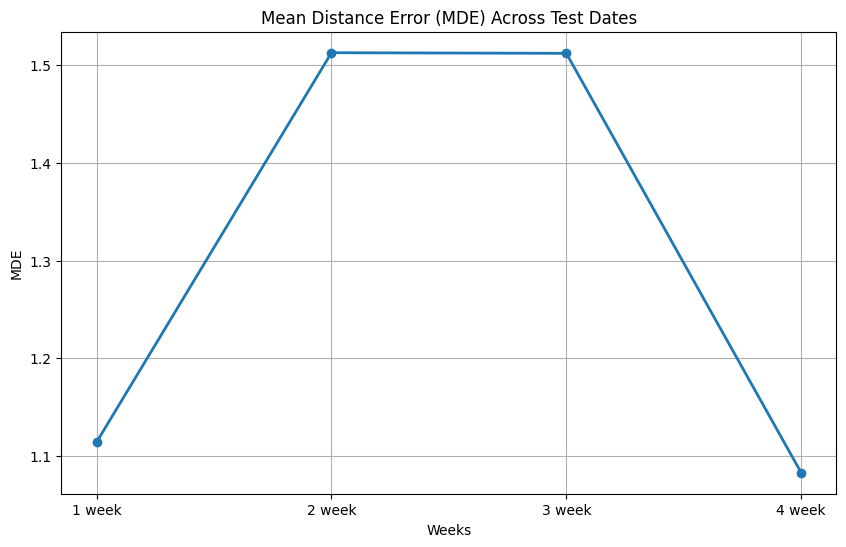

In [ ]:

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

testdate = ['2024_12_21', '2024_12_27', '2025_01_03', '2025_01_10']
with_data = 'Distance'

selected_columns = ['Label', 'AP1_Rssi','AP2_Rssi','AP3_Rssi','AP4_Rssi','AP1_Distance (mm)','AP2_Distance (mm)','AP3_Distance (mm)','AP4_Distance (mm)'] 


# Assume a placeholder model training process
model = knn


# Calculate MDE for each test date
mde_values = []
for date in testdate:
    test_data_path = f"timestamp_allignment_Balanced_{date}_rtt_logs.csv"
    try:
        test_data = pd.read_csv(test_data_path, usecols=selected_columns)
        # print(f"Processing data for {date}...")
        # print(f"Columns in the test data: {test_data.columns}")
        print(test_data.head())

        # Check if 'Label' column exists
        if 'Label' not in test_data.columns:
            print(f"Error: 'Label' column not found in the test data for {date}. Skipping this file.")
            continue

        # Calculate MDE
        mde = calculate_mde(model, test_data, selected_columns, True, 3)
        mde_values.append(mde)
    except FileNotFoundError:
        print(f"File not found: {test_data_path}. Skipping this test date.")
    except Exception as e:
        print(f"An error occurred for {date}: {e}")

# Print MDE values
print("Mean Distance Errors (MDE) for each test date:")
for i, mde in enumerate(mde_values):
    print(f"{testdate[i]}: {mde:.4f}")

# Plot MDE values
plt.figure(figsize=(10, 6))
weeks = ["1 week", "2 week", "3 week", "4 week"]
plt.plot(weeks[:len(mde_values)], mde_values, marker='o', linestyle='-', linewidth=2)
plt.title("Mean Distance Error (MDE) Across Test Dates")
plt.xlabel("Weeks")
plt.ylabel("MDE")
plt.grid(True)
plt.show()

